# House Prices - Advanced Regression Techniques

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process, neural_network
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_validate

from xgboost import XGBRegressor

In [2]:
# Load Data
train_df = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
test_df = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")

# For easier manipulating the dataframes
combined = [train_df, test_df]

train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Exploratory Data Analysis

In [3]:
def get_mi_scores(X: pd.DataFrame, y: pd.Series) -> pd.Series:
    '''
    Calculate MI score for each feature in the X dataframe.

    :param X: dataframe
    :param y: the target variable
    :returns: Series with mutual information scores
    '''
    
    # Features with missing values
    odd_features = X.columns[X.isna().any()]

    # Remove features with missing values
    X = X.drop(columns = odd_features)

    # Label Encode categorical features
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()

    # Create Series with MI scores
    mi_scores = pd.Series(
        data = mutual_info_regression(
            X = X,
            y = y,
            discrete_features = [t == np.dtype(float) for t in X.dtypes]
        ),
        name = "MI Scores",
        index = X.columns
    ).apply(lambda x: round(x, 3))
    
    # Add other features as NaN
    mi_scores = mi_scores.append(pd.Series([np.nan for _ in odd_features], index = odd_features))
    
    return mi_scores


def get_high_correlation_score(X: pd.DataFrame) -> pd.DataFrame:
    '''
    Applies a high correlation filter to the data.

    :param X: A pandas dataframe of features.
    :returns: The filtered data.
    '''
    
    # Label Encode categorical features
    for colname in X.select_dtypes(["object", "category"]):
        X.loc[:, colname], _ = X.loc[:, colname].factorize()

    # Calculate correlation, convert to Series and sort DESC
    corr_df = X.corr().abs()
    corrs = corr_df.unstack()
    corrs = corrs.apply(lambda x: round(x, 3)).sort_values(ascending = False)

    # Create dataframe with only features with correlation bigger than threshold marked
    corr_df = corrs[len(X.columns):].to_frame().reset_index()
    corr_df.columns = ['#1', '#2', 'corr']
    
    # Group by the top highest correlated feature and it's correlation rate
    corr_df = corr_df[corr_df.groupby(['#1'])['corr'].transform(max) == corr_df['corr']]
    corr_df.set_index('#1', inplace = True)
    corr_df.columns = ['highestCorr', 'corr']

    return corr_df


def get_range(X: pd.DataFrame) -> pd.DataFrame:
    '''
    calculates the min, max for each feature in X
    
    :param X: A pandas dataframe of features.
    :return: dataframe
    '''

    info_dict = X.describe().T[['std', 'min', '25%', '50%', '75%', 'max', 'mean']].round(3).to_dict()

    for col in X.select_dtypes(["object", "category"]).columns:
        info_dict['min'][col] = np.nan
        info_dict['max'][col] = np.nan
        
    return pd.DataFrame(data = info_dict)


def describe(X: pd.DataFrame, y: pd.DataFrame) -> pd.DataFrame:
    '''
    Analyzes the given data for EDA

    :param X: A pandas dataframe of features.
    :param y: The target variable series
    :returns: Evaluation dataframe
    '''
    
    # Avoid modifying the original data
    X = X.copy()
    
    # Create evaluation dataframe
    eval_df = pd.DataFrame(
        data = {
            'type': [X[col].dtype for col in X.columns]
        },
        index = X.columns
    )
    
    # Merge missing data percentage
    md_df = X.isna().sum().apply(lambda x: round(x / X.shape[0] * 100, 2))
    eval_df = eval_df.merge(md_df.rename('MDP'), left_index = True, right_index = True)
    
    # Merge range
    range_df = get_range(X)
    eval_df = pd.merge(eval_df, range_df, left_index = True, right_index = True)
    
    # Merge MI scores
    mi_scores = get_mi_scores(X, y)
    eval_df = eval_df.merge(mi_scores.rename('MI'), left_index = True, right_index = True)    
    
    # Merge highest correlated feature
    corr_df = get_high_correlation_score(X)
    eval_df = pd.merge(eval_df, corr_df, left_index = True, right_index = True)

    return eval_df

In [4]:
X = train_df.loc[:, train_df.columns != 'SalePrice']
y = train_df['SalePrice']

eval_df = describe(X, y)
eval_df.sort_values(by = 'MI', ascending = False).head(10)

,type,MDP,std,min,25%,50%,75%,max,mean,MI,highestCorr,corr
OverallQual,int64,0.0,1.383,1.0,5.00,6.0,7.00,10.0,6.099,0.519,GarageCars,0.601
GrLivArea,int64,0.0,525.480,334.0,1129.50,1464.0,1776.75,5642.0,1515.464,0.379,TotRmsAbvGrd,0.825
GarageCars,int64,0.0,0.747,0.0,1.00,2.0,2.00,4.0,1.767,0.374,GarageArea,0.882
ExterQual,object,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.320,KitchenQual,0.528
KitchenQual,object,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.319,ExterQual,0.528
GarageArea,int64,0.0,213.805,0.0,334.50,480.0,576.00,1418.0,472.980,0.278,GarageCars,0.882
TotalBsmtSF,int64,0.0,438.705,0.0,795.75,991.5,1298.25,6110.0,1057.429,0.258,1stFlrSF,0.820
YearBuilt,int64,0.0,30.203,1872.0,1954.00,1973.0,2000.00,2010.0,1971.268,0.252,GarageYrBlt,0.826
FullBath,int64,0.0,0.551,0.0,1.00,2.0,2.00,3.0,1.565,0.251,GrLivArea,0.630
1stFlrSF,int64,0.0,386.588,334.0,882.00,1087.0,1391.25,4692.0,1162.627,0.243,TotalBsmtSF,0.820


In [5]:
def k_fold(model, X, y, cv = 5):
    '''
    Perform k-fold cross validation.

    :param model: Model
    :param X: Features
    :param y: Target
    :param cv: Number of folds
    :return: Cross validation score
    '''

    return round(cross_validate(model, X, y, cv = cv)['test_score'].mean() * 100)


def evaluate(models, X = None, y = None, cv = 5):
    '''
    Evaluate all models

    :param X: Features
    :param y: Target
    :param cv: Number of folds
    :return: Evaluation DataFrame
    '''

    # Create DataFrame
    return pd.DataFrame(
        data = [k_fold(model, X, y, cv = cv) for name, model in models.items()],
        index = models.keys(),
        columns = ['Accuracy']
    ).sort_values(
        by = 'Accuracy',
        ascending = False
    )

In [6]:
models = {
    # Ensemble Methods
    'AdaBoostRegressor': ensemble.AdaBoostRegressor(),
    'BaggingRegressor': ensemble.BaggingRegressor(),
    'ExtraTreesRegressor': ensemble.ExtraTreesRegressor(),
    'GradientBoostingRegressor': ensemble.GradientBoostingRegressor(),
    'RandomForestRegressor': ensemble.RandomForestRegressor(),

    # Nearest Neighbor
    'KNeighborsRegressor': neighbors.KNeighborsRegressor(),

    # SVM
    'SVR': svm.SVR(),
    'NuSVR': svm.NuSVR(),
    'LinearSVR': svm.LinearSVR(max_iter = 1200000),

    # Trees    
    'DecisionTreeRegressor': tree.DecisionTreeRegressor(),
    'ExtraTreeRegressor': tree.ExtraTreeRegressor(),

    # XGBoost
    'XGBRegressor': XGBRegressor()    
}

In [7]:
features = eval_df.sort_values(by = 'MI', ascending = False).index[:1]
print(f'Features: {list(features)}')

Features: ['OverallQual']


In [8]:
# model_eval_df = evaluate (
#     models = models,
#     X = X[features],
#     y = y,
#     cv = 5
# )
# model_eval_df

In [9]:
# top_model_name = model_eval_df.iloc[0].name
# top_model = models[top_model_name]

# top_model.fit(X[features], y)
# pred = top_model.predict(test_df[features])

In [10]:
# submission_df = pd.DataFrame(data = {
#     'Id': test_df['Id'],
#     'SalePrice': pred
# })

# submission_df.to_csv(f'submission.csv', index = False)

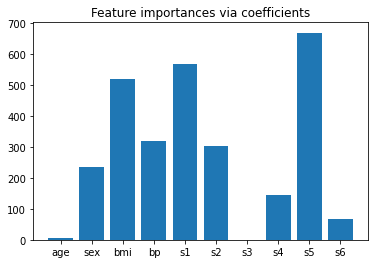

In [11]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LassoCV

diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target

lasso = LassoCV().fit(X, y)
importance = np.abs(lasso.coef_)
feature_names = np.array(diabetes.feature_names)
plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.show()

In [12]:
from sklearn.feature_selection import SequentialFeatureSelector

tic_fwd = time()
sfs_forward = SequentialFeatureSelector(lasso, n_features_to_select=2,
                                        direction='forward').fit(X, y)
toc_fwd = time()

tic_bwd = time()
sfs_backward = SequentialFeatureSelector(lasso, n_features_to_select=2,
                                         direction='backward').fit(X, y)
toc_bwd = time()

print("Features selected by forward sequential selection: "
      f"{feature_names[sfs_forward.get_support()]}")
print(f"Done in {toc_fwd - tic_fwd:.3f}s")
print("Features selected by backward sequential selection: "
      f"{feature_names[sfs_backward.get_support()]}")
print(f"Done in {toc_bwd - tic_bwd:.3f}s")

ImportError: cannot import name 'SequentialFeatureSelector' from 'sklearn.feature_selection' (/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/__init__.py)